### Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import keras.backend as K
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import quad
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from keras import backend
import time
from sklearn.cross_decomposition import CCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### $\Phi$

[[1.00000000e+00 7.78190965e-04]
 [7.78190965e-04 1.00000000e+00]]


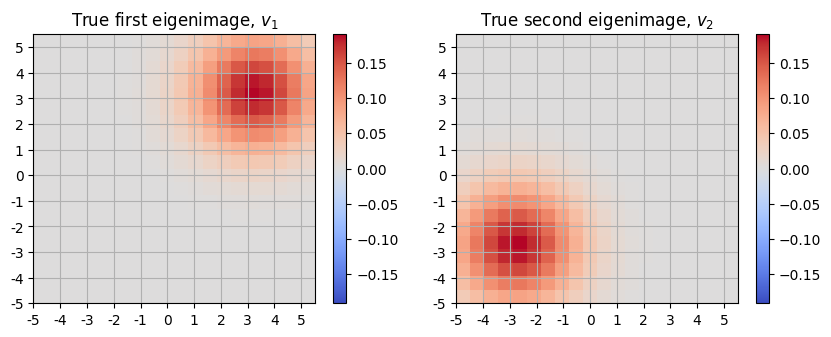

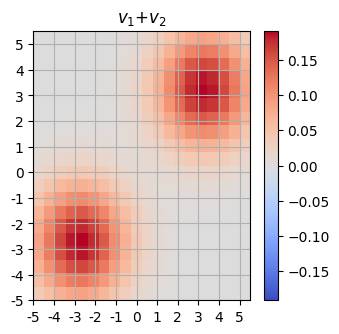

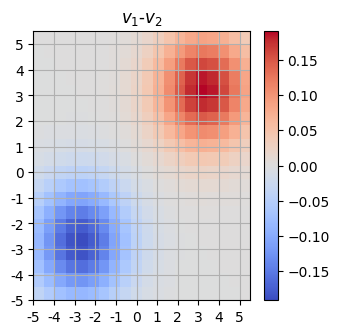

array([[1.00000000e+00, 7.78190965e-04],
       [7.78190965e-04, 1.00000000e+00]])

In [3]:
dims = 20
dimsquare = dims*dims
# 生成x和y的值
x = np.linspace(-5, 5, dims)
y = np.linspace(-5, 5, dims)
# 创建网格坐标
X, Y = np.meshgrid(x, y)
phi1 = np.exp(-(0.2*((X-3)**2)+(0.2*(Y-3)**2)))


phi2 = np.exp(-((0.2*(X+3)**2)+(0.2*(Y+3)**2)))

phi1 = phi1/np.sqrt(np.sum(phi1**2))
phi2 = phi2/np.sqrt(np.sum(phi2**2))




phit = pd.DataFrame([np.reshape(phi1,dimsquare),np.reshape(phi2,dimsquare)])
phit = np.array(phit)
maxx = np.max(phit)
minx = -np.max(phit)
print(phit.dot(np.transpose(phit)))
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
# Plot the first loading vector
ax[0].set_xticks(np.linspace(0, dims-1, 11))
ax[0].set_yticks(np.linspace(0, dims-1, 11))
ax[0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax[0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
img = ax[0].pcolormesh(np.reshape(phi1, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax[0].grid()
ax[0].set_title(r'True first eigenimage, $v_1$')
fig.colorbar(img, ax=ax[0])

# Plot the second loading vector
ax[1].set_xticks(np.linspace(0, dims-1, 11))
ax[1].set_yticks(np.linspace(0, dims-1, 11))
ax[1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax[1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax[1].grid() # add grid
img = ax[1].pcolormesh(np.reshape(phi2, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax[1].set_title(r'True second eigenimage, $v_2$')
fig.colorbar(img, ax=ax[1])


fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# Plot the first loading vector
ax.set_xticks(np.linspace(0, dims-1, 11))
ax.set_yticks(np.linspace(0, dims-1, 11))
ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
img = ax.pcolormesh(np.reshape(phi1+phi2, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax.grid()
ax.set_title(r'$v_1$+$v_2$')
fig.colorbar(img, ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# Plot the first loading vector
ax.set_xticks(np.linspace(0, dims-1, 11))
ax.set_yticks(np.linspace(0, dims-1, 11))
ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
img = ax.pcolormesh(np.reshape(phi1-phi2, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax.grid()
ax.set_title(r'$v_1$-$v_2$')
fig.colorbar(img, ax=ax)
plt.show()



projection = np.reshape(phit[0,:],(dimsquare,1)).dot(np.reshape(phit[0,:],(1,dimsquare)))+np.reshape(phit[1,:],(dimsquare,1)).dot(np.reshape(phit[1,:],(1,dimsquare)))
'''
fig, ax = plt.subplots(1, 1, figsize=(3,3))
# Plot the first loading vector
ax.set_xticklabels([])
ax.set_yticklabels([])
img = ax.pcolormesh(np.reshape(projection, (dimsquare, dimsquare)), cmap='coolwarm', vmax=np.max(projection), vmin=np.min(projection))
ax.set_title('Projection matrix')
cax2 = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # x, y, width, height
fig.colorbar(img, cax=cax2)
plt.show()
'''
phit.dot(np.transpose(phit))

### 2D linear

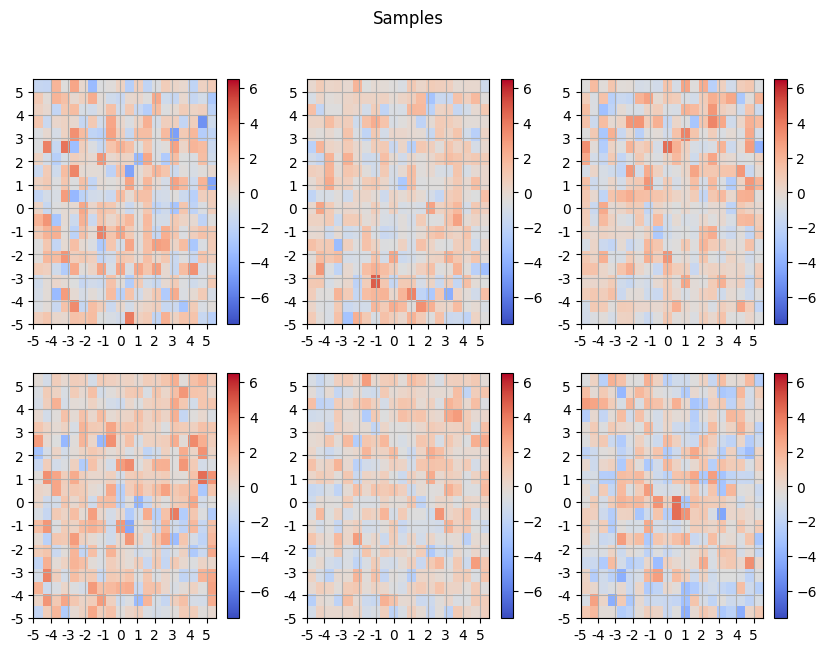

In [4]:
def poissondatagenerator(phit = phit, seeds = 10, means = [0,0], covmat = np.diag([9,4]), numsample = 500, dim2 = 2, num_plots=6, nl = 0):
    np.random.seed(seed=seeds+3)
    xdim = int(np.sqrt(phit.shape[1]))
    xi = np.random.multivariate_normal(means,covmat,numsample)

    dim = phit.shape[1]
    np.random.seed(seed=(seeds+3)*2)
    epsilon = np.reshape(np.random.normal(0,1,numsample*dim),(numsample,dim))
    np.random.seed(seed=(seeds+1283)*2)
    epsilon2 = []
    for i in range(dim):
      if i % 2 ==0:
        epsilon2.append(np.reshape(np.random.normal(0,1.5,numsample),(numsample)))
      if i % 2 ==1:
        epsilon2.append(np.reshape(np.random.normal(0,1,numsample),(numsample)))
    epsilon2 = np.reshape(epsilon2,(numsample,dim))
    z = xi.dot(phit)+epsilon
    if nl == 1:
      z = xi.dot(phit)+epsilon2

    '''
    np.random.seed(seed=(seeds+3)*2)
    z = np.random.poisson(np.exp(xi.dot(phit)))
    '''
    lambda_ = xi.dot(phit)

    np.random.seed(seed=(seeds+3)*3)
    #Y = lambda_
    Y = z
    Y2 = xi.dot(phit)
    if covmat[1,1] == 0:
      projection = np.reshape(phit[0,:],(dims,1)).dot(np.reshape(phit[0,:],(1,dims)))
    else:
      projection = np.reshape(phit[0,:],(dim,1)).dot(np.reshape(phit[0,:],(1,dim)))+np.reshape(phit[1,:],(dim,1)).dot(np.reshape(phit[1,:],(1,dim)))

    if dim2 == 2:
      fig, axs = plt.subplots(2, 3, figsize=(10, 7))
      for i in range(num_plots):
          row = i // 3
          col = i % 3
          axs[row, col].set_xticks(np.linspace(0, dims-1, 11))
          axs[row, col].set_yticks(np.linspace(0, dims-1, 11))
          axs[row, col].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axs[row, col].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axs[row, col].grid()
          img = axs[row, col].pcolormesh(np.reshape(Y[i], (xdim, xdim)), cmap='coolwarm', vmax = np.max(Y), vmin = np.min(Y))
          fig.colorbar(img, ax=axs[row, col])

      fig.suptitle('Samples')
      plt.show()


    if dim2 == 1:
      fig, axs = plt.subplots(2, 3, figsize=(10, 6))
      x_ticks = np.linspace(-5, 5, 9)  # 目标x轴刻度值

      for i in range(num_plots):
          row = i // 3
          col = i % 3
          axs[row, col].plot(Y[i])
          axs[row, col].set_xticks(np.linspace(0, dim-1, 9))  # 设置刻度位置
          axs[row, col].set_xticklabels([int(tick) for tick in x_ticks])  # 设置刻度标签
          #axs[row, col].set_yticks(np.linspace(-4, 4, 7))  # 设置刻度位置
          #axs[row, col].set_yticklabels([int(tick) for tick in np.linspace(-4, 4, 7)])  # 设置刻度标签

          axs[row, col].set_title(f'Sample {i+1}')
      fig.suptitle('Samples')
      plt.show()

    return Y, projection, lambda_


Y, projection, lambda_= poissondatagenerator(nl = 1)

### cae

In [5]:
def cae11(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', regg = 1, dense = 1, n_filter = 10):
  '''
  xdim: 輸入資料的寬度
  kernelshape0: kernel的寬度
  activations:
  j: L1 regularizer
  ncomp: 降維維度
  pcloading: initialization
  padding0: 是否使用same padding
  regg: 1:有L1 penalty, 否則都沒有，也沒有initialization
  dense: 1:只用fully connected layer，否則有用convoultional layer

  '''
  #initialization
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0

  for i in range(kernelshape0):
    for k in range(kernelshape0):
      kernel_init[i, k]=np.exp(-((i-kernelshape0/2+0.5)**2+(k-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))

  b = tf.keras.initializers.Constant(kernel_init)
  #Loss
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  #constraint
  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  #dense only
  if dense == 1:
    if regg == 1:
      print(f'Dense 1, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))
      #x = layers.Conv2D(1,kernel_size = kernelshape0, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(inputs)
      x = layers.Flatten()(inputs)
      code = layers.Dense(ncomp,name = 'code', kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a, activation = activations)(x)
      x = layers.Dense(xdim*xdim, activation = None, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)


      x = layers.Flatten()(x)
      cae1 = Model(inputs = inputs, outputs = x)
      cae1.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory1 = CAELossHistory()

    else:
      print(f'Dense 1, NO reg')
      inputs = keras.Input((xdim,xdim,1))
      #x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(inputs)
      x = layers.Flatten()(inputs)
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      x = layers.Dense(xdim*xdim, activation = None)(code)
      x = layers.Flatten()(x)

      cae1 = Model(inputs = inputs, outputs = x)
      cae1.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory1 = CAELossHistory()
  #Conv
  else:
    if regg == 1:
      print(f'Conv 1, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))
      #1 conv layer
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)

      x = layers.Flatten()(x)
      #dimension reduction
      code = layers.Dense(ncomp,name = 'code', activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)

      x = layers.Flatten()(x)
      cae1 = Model(inputs = inputs, outputs = x)
      cae1.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory1 = CAELossHistory()
    else:
      print('Conv 1, NO reg')
      inputs = keras.Input((xdim,xdim,1))
      #1 conv layer
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)

      x = layers.Flatten()(x)
      #dimension reduction
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)

      x = layers.Flatten()(x)
      cae1 = Model(inputs = inputs, outputs = x)
      cae1.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory1 = CAELossHistory()

  return cae1, CAEhistory1

def cae31(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', regg=1, dense = 1, n_filter = 10):
  '''
  xdim: 輸入資料的寬度
  kernelshape0: kernel的寬度
  activations:
  j: L1 regularizer
  ncomp: 降維維度
  pcloading: initialization
  padding0: 是否使用same padding
  regg: 1:有L1 penalty, 否則都沒有，也沒有initialization
  dense: 1:只用fully connected layer，否則有用convoultional layer

  '''
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None

  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  if dense == 1:
    if regg == 1:
      print(f'Dense 3, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Flatten()(inputs)
      x = layers.Dense(int(xdim*xdim/2), activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', kernel_regularizer=tf.keras.regularizers.L1(j), activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/2), activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
      #,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading))
      x = layers.Dense(xdim*xdim, activation = None, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)


      x = layers.Flatten()(x)
      cae3 = Model(inputs = inputs, outputs = x)
      cae3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory3 = CAELossHistory()
    else:
      print(f'Dense 3, NO reg')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Flatten()(inputs)
      x = layers.Dense(int(xdim*xdim/2), activation = activations)(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/2), activation = activations)(code)
      #,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading))
      x = layers.Dense(xdim*xdim, activation = None)(x)
      x = layers.Flatten()(x)
      cae3 = Model(inputs = inputs, outputs = x)
      cae3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory3 = CAELossHistory()

  else:
    if regg == 1:
      print(f'Conv 3, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Conv2D(n_filter ,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = padding0, activation = activations)(x)
      x = layers.Flatten()(x)

      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)


      x = layers.Flatten()(x)
      cae3 = Model(inputs = inputs, outputs = x)
      cae3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory3 = CAELossHistory()
    else:
      print('Conv 3')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Conv2D(n_filter ,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = padding0, activation = activations)(x)
      x = layers.Flatten()(x)

      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)


      x = layers.Flatten()(x)
      cae3 = Model(inputs = inputs, outputs = x)
      cae3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory3 = CAELossHistory()

  return cae3, CAEhistory3

def cae51(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', regg=1, dense = 1, n_filter = 10):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  if dense ==1:
    if regg==1:
      print(f'Dense 5, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Flatten()(inputs)
      x = layers.Dense(int(2*xdim*xdim/3), activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      x = layers.Dense(int(xdim*xdim/3), activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', kernel_regularizer=tf.keras.regularizers.L1(j), activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/3), activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
      x = layers.Dense(int(2*xdim*xdim/3), activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)
      #,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading))
      x = layers.Dense(xdim*xdim, activation = None, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)


      x = layers.Flatten()(x)
      cae5 = Model(inputs = inputs, outputs = x)
      cae5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory5 = CAELossHistory()
    else:
      print(f'Dense 5, NO reg')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Flatten()(inputs)
      x = layers.Dense(int(2*xdim*xdim/3), activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/3), activation = activations)(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/3), activation = activations)(code)
      x = layers.Dense(int(2*xdim*xdim/3), activation = activations)(x)
      #,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading))
      x = layers.Dense(xdim*xdim, activation = None)(x)


      x = layers.Flatten()(x)
      cae5 = Model(inputs = inputs, outputs = x)
      cae5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory5 = CAELossHistory()
  else:
    if regg == 1:
      print(f'Conv 5, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))

      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(x)

      x = layers.Flatten()(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)


      x = layers.Flatten()(x)
      cae5 = Model(inputs = inputs, outputs = x)
      cae5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory5 = CAELossHistory()
    else:
      print('Conv 5, NO reg')
      inputs = keras.Input((xdim,xdim,1))

      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(x)

      x = layers.Flatten()(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)


      x = layers.Flatten()(x)
      cae5 = Model(inputs = inputs, outputs = x)
      cae5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory5 = CAELossHistory()
  return cae5, CAEhistory5

def cae71(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', regg = 1, dense = 1, n_filter = 10):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  b = np.zeros((kernelshape0,kernelshape0))
  b[int(kernelshape0/2-0.5),int(kernelshape0/2-0.5)] = 1
  if dense == 1:
    if regg==1:
      print(f'Dense 7, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))
      x = layers.Flatten()(inputs)
      x = layers.Dense(int(3*xdim*xdim/4), activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      x = layers.Dense(int(2*xdim*xdim/4), activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      x = layers.Dense(int(xdim*xdim/4), activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', kernel_regularizer=tf.keras.regularizers.L1(j), activation =activations)(x)
      x = layers.Dense(xdim*xdim, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
      x = layers.Dense(int(xdim*xdim/4), activation = activations,  kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)
      x = layers.Dense(int(2*xdim*xdim/4), activation = activations,  kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)
      x = layers.Dense(int(3*xdim*xdim/4), activation = activations,  kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)
      x = layers.Dense(int(xdim*xdim/4), activation = None,  kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(x)
      x = layers.Flatten()(x)
      cae7 = Model(inputs = inputs, outputs = x)
      cae7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory7 = CAELossHistory()

    else:
      print(f'Dense 7, NO reg')
      inputs = keras.Input((xdim,xdim,1))
      '''
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(inputs)
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = False, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
      '''
      x = layers.Flatten()(inputs)
      x = layers.Dense(int(3*xdim*xdim/4), activation = activations)(x)
      x = layers.Dense(int(2*xdim*xdim/4), activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/4), activation = activations)(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      x = layers.Dense(int(xdim*xdim/4), activation = activations)(code)
      x = layers.Dense(int(2*xdim*xdim/4), activation = activations)(x)
      #,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading))
      x = layers.Dense(int(3*xdim*xdim/4), activation = activations)(x)
      x = layers.Dense(xdim*xdim, activation = None)(x)

      x = layers.Flatten()(x)
      cae7 = Model(inputs = inputs, outputs = x)
      cae7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory7 = CAELossHistory()

  else:
    if regg==1:
      print(f'Conv 7, reg = {j}')
      inputs = keras.Input((xdim,xdim,1))

      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = 'same', activation = activations)(x)

      x = layers.Flatten()(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations, kernel_regularizer=tf.keras.regularizers.L1(j))(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)

      x = layers.Flatten()(x)
      cae7 = Model(inputs = inputs, outputs = x)
      cae7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory7 = CAELossHistory()
    else:
      print(f'Conv 7, NO reg')
      inputs = keras.Input((xdim,xdim,1))

      x = layers.Conv2D(n_filter,kernel_size = kernelshape0, padding = padding0, activation = activations)(inputs)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = padding0, activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter,kernel_size = kernelshape0 , padding = 'same', activation = activations)(x)

      x = layers.Flatten()(x)
      #,kernel_initializer=a
      code = layers.Dense(ncomp,name = 'code', activation = activations)(x)
      #back to high dim
      x = layers.Dense(xdim*xdim, activation = activations)(code)
      #reshape to do conv
      x = layers.Reshape(((xdim,xdim,1)))(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(n_filter, kernel_size = kernelshape0, padding = 'same', activation = activations)(x)
      x = layers.Conv2D(1,kernel_size = kernelshape0, padding = 'same', activation = None)(x)

      x = layers.Flatten()(x)
      cae7 = Model(inputs = inputs, outputs = x)
      cae7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
      CAEhistory7 = CAELossHistory()
  return cae7, CAEhistory7


### 2D functions

In [6]:

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import keras.backend as K
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
import numpy as np

#lambdas = np.concatenate([np.repeat(0.0,7),np.repeat(0.05,7)])
size = [3, 7, 11]
ncomps = [2, 3, 4]
n_filters = [1]
def spatialAE2D(Y = Y, ncomp = ncomps, activations = None, epoches = 1200, dx = 0.1, phit = phit, p = projection,kernelshape = size, conti = 1, lambda_ = lambda_, padding0 = 'same', regg = 1, dense = 1, n_filters = n_filters):
  xdim = int(np.sqrt(Y.shape[1]))
  dims = Y.shape[1]
  '''
  for i in range(Y.shape[1]):
     Y[:,i] = Y[:,i] - np.mean(Y[:,i])
  '''
  if regg == 1:
    lambda1 = np.round(np.linspace(0, 0.8, 4),4)
  else:
    lambda1 = [0]
  if dense == 1:
    kernelshape = [3]
    n_filters = [5]
  Y_train, Y_test,lambda_train,lambda_test = train_test_split(Y,lambda_, test_size = 0.2, random_state=42)
  Y_train, Y_valid = train_test_split(Y_train, test_size = 0.2, random_state=30)
  Y_train = Y_train*1.0
  Y_valid = Y_valid*1.0
  Y_test = Y_test*1.0
  lambda_train,lambda_test = lambda_train*1.0 ,lambda_test*1.0


  loss31 = []
  loss21 = []
  loss41 = []
  loss33 = []
  loss23 = []
  loss43 = []
  loss35 = []
  loss25 = []
  loss45 = []
  gridsearchcae1 = []
  gridsearchcae3 = []
  gridsearchcae5 = []

  ressaes = []
  gridsearchsae = []
  respcas = []
  resspcas = []
  respcavalids = []
  resspcavalids = []
  gridsearchspca = []

  fubae21 = []
  fubae31 = []
  fubae41 = []
  fubae23 = []
  fubae33 = []
  fubae43 = []
  fubae25 = []
  fubae35 = []
  fubae45 = []
  fubsaes = []
  fubspcas = []
  sfubindex = []
  cfub1index = []
  cfub3index = []
  cfub5index = []
  gridindex = 0

  start_time = time.time()
  for ncomp in ncomps:
    for kernelshape0 in kernelshape:
      for n_filter in n_filters:
        lambdaindex = 0
        for j in lambda1:
          gridindex = gridindex + 1
          #PCA
          pca = PCA(n_components=ncomp)
          pca.fit(Y_train)
          pcloading = np.transpose(pca.components_)
          ppca = pcloading.dot(np.transpose(pcloading))
          #ppca = pcloading.dot(np.diag(pca.singular_values_)).dot(np.transpose(pcloading))
          pctrain = pca.fit_transform(Y_train)
          pctest = pca.transform(Y_test)
          pcvalid = pca.transform(Y_valid)
          reconpcatrain = pca.inverse_transform(pctrain)
          reconpcatest = pca.inverse_transform(pctest)
          reconpcavalid = pca.inverse_transform(pcvalid)
          respcatrain = np.mean(tf.keras.metrics.mean_squared_error(reconpcatrain,Y_train))
          respcatest = np.mean(tf.keras.metrics.mean_squared_error(reconpcatest,Y_test))
          respcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconpcavalid,Y_valid))
          respcas.append(respcatest)
          respcavalids.append(respcavalid)
          pcalhat = np.mean(reconpcatest,axis = 0)
          pcatestgof = np.mean(np.mean((reconpcatest-lambda_test)**2))


          #SPCA
          '''
          spca = SparsePCA(n_components=ncomp,alpha = j*25, max_iter = 50)
          spca.fit(Y_train)
          spcloading = np.transpose(spca.components_)
          spctrain = spca.fit_transform(Y_train)
          spctest = spca.transform(Y_test)
          spcvalid = spca.transform(Y_valid)
          spccov = pd.DataFrame.cov(pd.DataFrame(spctrain))
          reconspcatrain = spca.inverse_transform(spctrain)
          reconspcatest = spca.inverse_transform(spctest)
          reconspcavalid = spca.inverse_transform(spcvalid)
          pspca = spcloading.dot(np.transpose(spcloading).dot(spcloading)).dot(np.transpose(spcloading))
          #pspca = spcloading.dot(spccov).dot(np.transpose(spcloading))
          resspcatrain = np.mean(tf.keras.metrics.mean_squared_error(reconspcatrain,Y_train))
          resspcatest = np.mean(tf.keras.metrics.mean_squared_error(reconspcatest,Y_test))
          resspcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
          resspcas.append(resspcatest)
          gridsearchspca.append(resspcatest)
          resspcavalids.append(resspcavalid)
          spcalhat = np.mean(reconspcatest,axis = 0)
          spcatestgof = np.mean(np.mean((reconspcatest-lambda_test)**2))
          '''
          #print('SPCA loading',np.transpose(spcloading).dot(spcloading))
          #CAE
          cae1, CAEhistory1 = cae11(xdim , kernelshape0 , activations , j ,ncomp, pcloading, regg = regg, dense = dense, n_filter = n_filter)
          cae3, CAEhistory3 = cae31(xdim , kernelshape0 , activations , j ,ncomp, pcloading, regg = regg, dense = dense, n_filter = n_filter)
          cae5, CAEhistory5 = cae51(xdim , kernelshape0 , activations , j ,ncomp, pcloading, regg = regg, dense = dense, n_filter = n_filter)
          cae7, CAEhistory7 = cae71(xdim , kernelshape0 , activations , j ,ncomp, pcloading, regg = regg, dense = dense, n_filter = n_filter)

          early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=300)

          #weight loading
          lambdaindex = lambdaindex+1
          j2 = np.array(lambda1)
          if lambdaindex > 1:
            j3 = j2[lambdaindex-2]
            cae1.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory1,early_stopping], batch_size = Y_train.shape[0])
            cae3.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory3,early_stopping], batch_size = Y_train.shape[0])
            cae5.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory5,early_stopping], batch_size = Y_train.shape[0])
            cae7.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory7,early_stopping], batch_size = Y_train.shape[0])


          else:

            cae1.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory1,early_stopping], batch_size = Y_train.shape[0])
            cae3.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory3,early_stopping], batch_size = Y_train.shape[0])
            cae5.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory5,early_stopping], batch_size = Y_train.shape[0])
            cae7.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory7,early_stopping], batch_size = Y_train.shape[0])

          if dense == 1:
            layers = [2,3,4,5]
          else:
            layers = [3,4,6,9]
          cae_get_code_layer_output1 = K.function([cae1.layers[0].input],[cae1.layers[layers[0]].output])
          cae_get_code_layer_output3 = K.function([cae3.layers[0].input],[cae3.layers[layers[1]].output])
          cae_get_code_layer_output5 = K.function([cae5.layers[0].input],[cae5.layers[layers[2]].output])
          cae_get_code_layer_output7 = K.function([cae7.layers[0].input],[cae7.layers[layers[3]].output])

          caecode1 = cae_get_code_layer_output1(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
          caecode3 = cae_get_code_layer_output3(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
          caecode5 = cae_get_code_layer_output5(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
          caecode7 = cae_get_code_layer_output7(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]

          if activations == 'linear':
            print('using',activations,'estimating the loadings')
            #CAE estimation
            eaephi1 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode1)
            eaephi3 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode3)
            eaephi5 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode5)
            eaephi7 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode7)

          else:
            print('using',activations,'estimating the loadings')
            layer_output = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
            layer_output1 = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

            layer_output2 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
            layer_output3 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

            layer_output4 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
            layer_output5 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]


            layer_output8 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
            layer_output9 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

            #gradient = layer_output
            eaephi1 = (layer_output-layer_output1)/dx
            eaephi3 = (layer_output2-layer_output3)/dx
            eaephi5 = (layer_output4-layer_output5)/dx
            eaephi7 = (layer_output8-layer_output9)/dx


          for i in range(ncomp):
            eaephi1[:,i] = eaephi1[:,i]/np.sqrt(np.sum(eaephi1[:,i]**2))
            eaephi3[:,i] = eaephi3[:,i]/np.sqrt(np.sum(eaephi3[:,i]**2))
            eaephi5[:,i] = eaephi5[:,i]/np.sqrt(np.sum(eaephi5[:,i]**2))
            eaephi7[:,i] = eaephi7[:,i]/np.sqrt(np.sum(eaephi7[:,i]**2))


          cae_reconstruct1 = cae1.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct1test = cae1.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct1valid = cae1.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct3 = cae3.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct3test = cae3.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct3valid = cae3.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct5 = cae5.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct5test = cae5.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct5valid = cae5.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct7 = cae7.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct7test = cae7.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct7valid = cae7.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)



          caeres1test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1test,np.reshape(Y_test,(Y_test.shape[0],xdim*xdim))))
          caeres3test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3test,np.reshape(Y_test,(Y_test.shape[0],xdim*xdim))))
          caeres5test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5test,np.reshape(Y_test,(Y_test.shape[0],xdim*xdim))))
          caeres7test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct7test,np.reshape(Y_test,(Y_test.shape[0],xdim*xdim))))

          caeres1valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1valid,np.reshape(Y_valid,(Y_valid.shape[0],xdim*xdim))))
          caeres3valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3valid,np.reshape(Y_valid,(Y_valid.shape[0],xdim*xdim))))
          caeres5valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5valid,np.reshape(Y_valid,(Y_valid.shape[0],xdim*xdim))))
          caeres7valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct7valid,np.reshape(Y_valid,(Y_valid.shape[0],xdim*xdim))))


          #print(pcatestgof,spcatestgof,saetestgof,cae1testgof,cae3testgof,cae5testgof)
          #code


          ccode1mat = np.transpose(caecode1).dot(caecode1)
          ccode3mat = np.transpose(caecode3).dot(caecode3)
          ccode5mat = np.transpose(caecode5).dot(caecode5)
          ccode7mat = np.transpose(caecode7).dot(caecode7)

          c1sortindex = np.argsort(np.diag(ccode1mat))[::-1]
          c3sortindex = np.argsort(np.diag(ccode3mat))[::-1]
          c5sortindex = np.argsort(np.diag(ccode5mat))[::-1]
          c7sortindex = np.argsort(np.diag(ccode7mat))[::-1]


          if gridindex == 1:
            #pcafubindex = fubpca
            pcaresindex2 = respcatest
            pcaresindex = respcavalid
            pcabest = pca
            pcancomp = ncomp
            #pcalambdaindex = pcatestgof
            '''
            spcabest = spca
            spcalambdabest = j
            spcaresindex2 = resspcatest
            spcaresindex = resspcavalid
            spcancomp = ncomp
            #spcafubindex = fubspca
            #spcalambdaindex = spcatestgof
            '''


            if np.isnan(caeres1valid).any() == False:
              cae1best = cae1
              lambda1best = j
              kernel1best = kernelshape0
              n_filter1best = n_filter
              cres1index2 = caeres1test
              cres1index = caeres1valid
              cncomp1 = ncomp
              #cfub1index = fubcae1
              #cae1lambdaindex = cae1testgof
              c1 = 1
            elif np.isnan(caeres1valid).any()== True:
              c1 = 0
              print('CAE1 NONE')

            if np.isnan(caeres3valid).any() == False:
              cae3best = cae3
              lambda3best = j
              kernel3best = kernelshape0
              n_filter3best = n_filter
              cres3index2 = caeres3test
              cres3index = caeres3valid
              cncomp3 = ncomp
              #cfub3index = fubcae3
              #cae3lambdaindex = cae3testgof
              c3 = 1
            elif np.isnan(caeres3valid).any()== True:
              c3 = 0
              print('CAE3 NONE')

            if np.isnan(caeres5valid).any() == False:
              cae5best = cae5
              lambda5best = j
              kernel5best = kernelshape0
              n_filter5best = n_filter
              cres5index2 = caeres5test
              cres5index = caeres5valid
              cncomp5 = ncomp
              #cfub5index = fubcae5
              #cae5lambdaindex = cae5testgof
              c5 = 1
            elif np.isnan(caeres5valid).any()== True:
              c5 = 0
              print('CAE5 NONE')

            if np.isnan(caeres7valid).any() == False:
              cae7best = cae7
              lambda7best = j
              kernel7best = kernelshape0
              n_filter7best = n_filter
              cres7index2 = caeres7test
              cres7index = caeres7valid
              cncomp7 = ncomp
              #cfub7index = fubcae7
              #cae7lambdaindex = cae7testgof
              c7 = 1
            elif np.isnan(caeres7valid).any()== True:
              c7 = 0
              print('CAE7 NONE')


          else:
            if respcavalid < pcaresindex:
              #pcafubindex = fubpca
              pcaresindex2 = respcatest
              pcaresindex = respcavalid
              pcabest = pca
              pcancomp = ncomp
              #pcalambdaindex = pcatestgof

            '''
            if resspcavalid < spcaresindex:
              spcabest = spca
              spcalambdabest = j
              spcaresindex2 = resspcatest
              spcaresindex = resspcavalid
              spcancomp = ncomp
              #spcafubindex = fubspca
              #spcalambdaindex = spcatestgof
            '''



            if np.isnan(caeres1valid).any() == False and np.isnan(caeres1valid).any() == False:
              if c1 == 0:
                cae1best = cae1
                lambda1best = j
                kernel1best = kernelshape0
                cres1index2 = caeres1test
                cres1index = caeres1valid
                #CAEhistory1index = CAEhistory1
                cncomp1 = ncomp
                n_filter1best = n_filter
                #cfub1index = fubcae1
                #cae1lambdaindex = cae1testgof
                print(f'CAE1 Fubindex = {cres1index}, lambda = {j}')
              else:
                if caeres1valid < cres1index:
                  cae1best = cae1
                  lambda1best = j
                  kernel1best = kernelshape0
                  cres1index2 = caeres1test
                  cres1index = caeres1valid
                  n_filter1best = n_filter
                  #CAEhistory1index = CAEhistory1
                  cncomp1 = ncomp
                  #cfub1index = fubcae1
                  #cae1lambdaindex = cae1testgof
                  print(f'CAE1 resindex = {cres1index}, lambda = {j}')
                  s2 = 1
            elif np.isnan(caeres1valid).any()== True or np.isnan(caeres1valid).any() ==True:
              print('CAE1 NONE')


            if np.isnan(caeres3valid).any() == False and np.isnan(caeres3valid).any() == False:
              if c3 == 0:
                cae3best = cae3
                lambda3best = j
                kernel3best = kernelshape0
                cres3index2 = caeres3test
                cres3index = caeres3valid
                n_filter3best = n_filter
                #CAEhistory3index = CAEhistory3
                cncomp3 = ncomp
                #cfub3index = fubcae3
                #cae3lambdaindex = cae3testgof
                print(f'CAE3 resindex = {cres3index}, lambda = {j}')
              else:
                if caeres3valid < cres3index:
                  cae3best = cae3
                  lambda3best = j
                  kernel3best = kernelshape0
                  cres3index2 = caeres3test
                  cres3index = caeres3valid
                  n_filter3best = n_filter
                  #CAEhistory3index = CAEhistory3
                  cncomp3 = ncomp
                  #cfub3index = fubcae3
                  #cae3lambdaindex = cae3testgof
                  print(f'CAE3 resindex = {cres3index}, lambda = {j}')
                  c3 = 1
            elif np.isnan(caeres3valid).any()== True or np.isnan(caeres3valid).any() == True:
              print('CAE3 NONE')

            if np.isnan(caeres5valid).any() == False and np.isnan(caeres5valid).any() == False:
              if c5 == 0:
                cae5best = cae5
                lambda5best = j
                kernel5best = kernelshape0
                cres5index2 = caeres5test
                cres5index = caeres5valid
                n_filter5best = n_filter
                #CAEhistory5index = CAEhistory5
                cncomp5 = ncomp
                #cfub5index = fubcae5
                #cae5lambdaindex = cae5testgof
                print(f'CAE5 resindex = {cres5index}, lambda = {j}')
              else:
                if caeres5valid < cres5index:
                  cae5best = cae5
                  lambda5best = j
                  kernel5best = kernelshape0
                  cres5index2 = caeres5test
                  cres5index = caeres5valid
                  n_filter5best = n_filter
                  #CAEhistory5index = CAEhistory5
                  cncomp5 = ncomp
                  #cfub5index = fubcae5
                  #cae5lambdaindex = cae5testgof
                  print(f'CAE5 resindex = {cres5index}, lambda = {j}')
                  c5 = 1
            elif np.isnan(caeres5valid).any()== True or np.isnan(caeres5valid).any() == True:
              print('CAE5 NONE')

            if np.isnan(caeres7valid).any() == False and np.isnan(caeres7valid).any() == False:
              if c7 == 0:
                cae7best = cae7
                lambda7best = j
                kernel7best = kernelshape0
                cres7index2 = caeres7test
                cres7index = caeres7valid
                n_filter7best = n_filter
                #CAEhistory5index = CAEhistory5
                cncomp7 = ncomp
                #cfub7index = fubcae7
                #cae7lambdaindex = cae7testgof
                print(f'CAE7 resindex = {cres7index}')
              else:
                if caeres7valid < cres7index:
                  cae7best = cae7
                  lambda7best = j
                  kernel7best = kernelshape0
                  cres7index2 = caeres7test
                  cres7index = caeres7valid
                  n_filter7best = n_filter
                  #CAEhistory5index = CAEhistory5
                  cncomp7 = ncomp
                  #cfub7index = fubcae7
                  #cae7lambdaindex = cae7testgof
                  print(f'CAE7 resindex = {cres7index}')
                  c7 = 1
            elif np.isnan(caeres7valid).any()== True or np.isnan(caeres7valid).any() == True:
              print('CAE7 NONE')


          '''
          if dense == 1:

            plt.plot(CAEhistory1.losses,c = 'blue')
            plt.plot(CAEhistory3.losses,c = 'blue',linestyle = 'dashed')
            plt.plot(CAEhistory5.losses,c = 'blue',linestyle = 'dotted')
            plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')
            plt.axhline(respcatrain,c = 'red')
            #plt.axhline(resspcatrain,c = 'orange')
            plt.legend([fr'AE 1 layers',
                        fr'AE 2 layers',
                        fr'AE 3 layers',
                        fr'AE 4 layers',
                        'PCA'
                        ])
            plt.title(f'TRAINING MSE, $\lambda$ = {j}, ncomp: {ncomp}')
            plt.xlabel('Epoch')
            plt.ylabel('TRAINING MSE')
            plt.ylim((0,2.5))
            plt.show()

            plt.plot(CAEhistory1.l1_penalty_sum,c = 'blue')
            plt.plot(CAEhistory3.l1_penalty_sum,c = 'blue',linestyle = 'dashed')
            plt.plot(CAEhistory5.l1_penalty_sum,c = 'blue',linestyle = 'dotted')
            plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')

            plt.legend([fr'AE 1 layers',
                          fr'AE 2 layers',
                          fr'AE 3 layers',
                          fr'AE 4 layers',
                          'PCA'
                          ])
            plt.title(f'L1 sum, $\lambda$ = {j}, ncomp: {ncomp}')
            plt.xlabel('Epoch')
            plt.ylabel('L1 sum')
            plt.show()

          else:

            plt.plot(CAEhistory1.losses,c = 'blue')
            plt.plot(CAEhistory3.losses,c = 'blue',linestyle = 'dashed')
            plt.plot(CAEhistory5.losses,c = 'blue',linestyle = 'dotted')
            plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')
            plt.axhline(respcatrain,c = 'red')
            #plt.axhline(resspcatrain,c = 'orange')
            plt.legend([fr'SAEC 1 conv layer',
                        fr'SAEC 3 conv layer',
                        fr'SAEC 5 conv layer',
                        fr'SAEC 7 conv layer',
                        'PCA'
                        ])
            plt.title(f'TRAINING MSE, $\lambda$ = {j}, ncomp: {ncomp}, n_filter={n_filter}, kernelshape = {kernelshape0}')
            plt.xlabel('Epoch')
            plt.ylabel('TRAINING MSE')
            plt.ylim((0,2.5))
            plt.show()
          '''
          '''
          print('PCA LOSS',respcatrain)
          print(f'CAE1 TRAINING MSE, $\lambda$ = {j}, ncomp: {ncomp}, n_filter={n_filter}, kernelshape = {kernelshape0}',CAEhistory1.losses[:5],CAEhistory1.losses[-5:],len(CAEhistory1.losses))
          print('CAE3 LOSS',CAEhistory3.losses[:5],CAEhistory3.losses[-5:],len(CAEhistory3.losses))
          print('CAE4 LOSS',CAEhistory5.losses[:5],CAEhistory5.losses[-5:],len(CAEhistory5.losses))
          print('CAE7 LOSS',CAEhistory7.losses[:5],CAEhistory7.losses[-5:],len(CAEhistory7.losses))

          print('PCA valid LOSS',respcavalid)
          print('CAE1 valid LOSS',caeres1valid)
          print('CAE3 valid LOSS',caeres3valid)
          print('CAE4 valid LOSS',caeres5valid)
          print('CAE7 valid LOSS',caeres7valid)

          print('PCA test LOSS',respcatest)
          print('CAE1 test LOSS',caeres1test)
          print('CAE3 test LOSS',caeres3test)
          print('CAE4 test LOSS',caeres5test)
          print('CAE7 test LOSS',caeres7test)
          '''



          del cae1,cae3, cae5, cae7
  end_time = time.time()  # 記錄結束時間
  elapsed_time = end_time - start_time  # 計算經過時間
  '''
  resspcavalids = []

  bestspcalambda = 0
  spcabest = SparsePCA(n_components=ncomp,alpha = bestspcalambda)
  spcabest.fit(Y_train)
  spcloading = np.transpose(spcabest.components_)
  spctrain = spcabest.fit_transform(Y_train)
  spctest = spcabest.transform(Y_test)
  spcvalid = spcabest.transform(Y_valid)
  spccov = pd.DataFrame.cov(pd.DataFrame(spctrain))
  reconspcatrain = spca.inverse_transform(spctrain)
  reconspcatest = spca.inverse_transform(spctest)
  reconspcavalid = spca.inverse_transform(spcvalid)
  pspca = spcloading.dot(np.transpose(spcloading).dot(spcloading)).dot(np.transpose(spcloading))
  spcaresindex2 = np.mean(tf.keras.metrics.mean_squared_error(reconspcatest,Y_test))
  spcaresindex = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
  spcalhat = np.mean(reconspcatest,axis = 0)
  spcatestgof = np.mean(np.mean((reconspcatest-lambda_test)**2))
  '''


  #code
  cae_get_code_layer_output1 = K.function([cae1best.layers[0].input],[cae1best.layers[layers[0]].output])
  cae_get_code_layer_output3 = K.function([cae3best.layers[0].input],[cae3best.layers[layers[1]].output])
  cae_get_code_layer_output5 = K.function([cae5best.layers[0].input],[cae5best.layers[layers[2]].output])
  cae_get_code_layer_output7 = K.function([cae7best.layers[0].input],[cae7best.layers[layers[3]].output])

  caecode1 = cae_get_code_layer_output1(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
  caecode3 = cae_get_code_layer_output3(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
  caecode5 = cae_get_code_layer_output5(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
  caecode7 = cae_get_code_layer_output7(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]


  if activations == 'linear':
    #CAE estimation
    eaephi1 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode1)
    eaephi3 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode3)
    eaephi5 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode5)
    eaephi7 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode7)
  else:
    layer_output = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
    layer_output1 = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

    layer_output2 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
    layer_output3 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

    layer_output4 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
    layer_output5 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

    layer_output6 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
    layer_output7 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]


    #gradient = layer_output
    eaephi1 = (layer_output-layer_output1)/dx
    eaephi3 = (layer_output2-layer_output3)/dx
    eaephi5 = (layer_output4-layer_output5)/dx
    eaephi7 = (layer_output6-layer_output7)/dx


  for i in range(eaephi1.shape[1]):
    eaephi1[:,i] = eaephi1[:,i]/np.sqrt(np.sum(eaephi1[:,i]**2))
  for i in range(eaephi3.shape[1]):
    eaephi3[:,i] = eaephi3[:,i]/np.sqrt(np.sum(eaephi3[:,i]**2))

  for i in range(eaephi5.shape[1]):
    eaephi5[:,i] = eaephi5[:,i]/np.sqrt(np.sum(eaephi5[:,i]**2))
  for i in range(eaephi7.shape[1]):
    eaephi7[:,i] = eaephi7[:,i]/np.sqrt(np.sum(eaephi7[:,i]**2))

  #spcloadingbest = np.transpose(spcabest.components_)

  #pspcabest = spcloadingbest.dot(np.transpose(spcloadingbest).dot(spcloadingbest)).dot(np.transpose(spcloadingbest))
  pcloading = np.transpose(pcabest.components_)
  #ppca = pcloading.dot(np.transpose(pcloading))
  if dense ==1:
    plt.axhline(pcaresindex2,c = 'red')
    #plt.axhline(spcaresindex2,c = 'orange')

    plt.axhline(cres1index2,c = 'blue')
    plt.axhline(cres3index2,c = 'blue',linestyle = 'dashed')
    plt.axhline(cres5index2,c = 'blue',linestyle = 'dotted')
    plt.axhline(cres7index2,c = 'blue',linestyle = 'dashdot')
    plt.legend(['PCA',fr'SAE 1 layers, $\lambda$ = {lambda1best}, ncomp = {cncomp1}',
                fr'SAE 3 layers, $\lambda$ = {lambda3best}, ncomp = {cncomp3}',
                fr'SAE 5 layers, $\lambda$ = {lambda5best}, ncomp = {cncomp5}',
                fr'SAE 7 layers, $\lambda$ = {lambda7best}, ncomp = {cncomp7}'])
    plt.title(f'Grid Search Testing MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Testing MSE')
    plt.show()

  else:
    plt.axhline(pcaresindex2,c = 'red')
    #plt.axhline(spcaresindex2,c = 'orange')

    plt.axhline(cres1index2,c = 'blue')
    plt.axhline(cres3index2,c = 'blue',linestyle = 'dashed')
    plt.axhline(cres5index2,c = 'blue',linestyle = 'dotted')
    plt.axhline(cres7index2,c = 'blue',linestyle = 'dashdot')
    plt.legend(['PCA',fr'SAEC 1 layers, $\lambda$ = {lambda1best}, kernel size = {kernel1best}, n_filter = {n_filter1best}, ncomp = {cncomp1}',
                fr'SAEC 3 layers, $\lambda$ = {lambda3best}, kernel size = {kernel3best}, n_filter = {n_filter3best}, ncomp = {cncomp3}',
                fr'SAEC 5 layers, $\lambda$ = {lambda5best}, kernel size = {kernel5best}, n_filter = {n_filter5best}, ncomp = {cncomp5}',
                fr'SAEC 7 layers, $\lambda$ = {lambda7best}, kernel size = {kernel7best}, n_filter = {n_filter7best}, ncomp = {cncomp7}'])
    plt.title(f'Grid Search Testing MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Testing MSE')
    plt.show()

  fig, axes = plt.subplots(nrows=ncomp, ncols=3, figsize=(8.5,6))
  vmax = max(max(phit[0]), max(phit[1]))
  vmin = min(min(phit[0]), min(phit[1]))


  for i in range(2):
    # True loading plot 1

    img = axes[i, 0].pcolormesh(np.reshape(phit[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 0].set_title(f'True')
    axes[i, 0].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 0].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 0].grid()

    fig.colorbar(img, ax=axes[i, 0])


    # PCA loading plots
    if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
      pcabest.components_[i] = -pcabest.components_[i]
    img = axes[i, 1].pcolormesh(np.reshape(pcabest.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 1].set_title(f'PCA')
    axes[i, 1].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 1].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 1].grid()

    fig.colorbar(img, ax=axes[i, 1])
    '''
    # SPCA loading plots
    if np.max(np.abs(spcabest.components_[i])) == -np.min(spcabest.components_[i]):
      spcabest.components_[i] = -spcabest.components_[i]
    img = axes[i, 2].pcolormesh(np.reshape(spcabest.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 2].set_title(fr'SPCA')
    axes[i, 2].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 2].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 2].grid()
    fig.colorbar(img, ax=axes[i, 2])

    '''

  plt.tight_layout()
  plt.show()

  '''
  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,6))
  vmax = max(max(phit[0]), max(phit[1]))
  vmin = min(min(phit[0]), min(phit[1]))
  for i in range(2):
    # True loading plot 1


    # SCAE loading plots
    if np.max(np.abs(eaephi1[:,i])) == -np.min(eaephi1[:,i]):
      eaephi1[:,i] = -eaephi1[:,i]
    img = axes[i, 0].pcolormesh(np.reshape(eaephi1[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 0].set_title(fr'SAEC w/ 1 Conv2D layers')
    axes[i, 0].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 0].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 0].grid()

    fig.colorbar(img, ax=axes[i, 0])

    # SCAE loading plots
    if np.max(np.abs(eaephi3[:,i])) == -np.min(eaephi3[:,i]):
      eaephi3[:,i] = -eaephi3[:,i]
    img = axes[i, 1].pcolormesh(np.reshape(eaephi3[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 1].set_title(fr'SAEC w/ 2 Conv2D layers')
    axes[i, 1].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 1].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 1].grid()

    fig.colorbar(img, ax=axes[i, 1])

    # SCAE loading plots
    if np.max(np.abs(eaephi5[:,i])) == -np.min(eaephi5[:,i]):
      eaephi5[:,i] = -eaephi5[:,i]
    img = axes[i, 2].pcolormesh(np.reshape(eaephi5[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 2].set_title(fr'SAEC w/ 4 Conv2D layers')
    axes[i, 2].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 2].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 2].grid()

    fig.colorbar(img, ax=axes[i, 2])

    img = axes[i, 3].pcolormesh(np.reshape(eaephi7[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
    axes[i, 3].set_title(fr'SAEC w/ 7 Conv2D layers')
    axes[i, 3].set_xticks(np.linspace(0, xdim-1, 11))
    axes[i, 3].set_yticks(np.linspace(0, xdim-1, 11))
    axes[i, 3].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
    axes[i, 3].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

    fig.colorbar(img, ax=axes[i, 3])

  plt.tight_layout()
  plt.show()
  '''
  vmax = max(max(phit[0]), max(phit[1]))
  vmin = min(min(phit[0]), min(phit[1]))

  for i in range(2):
      fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10.5, 3))
      plt.subplots_adjust(wspace=0.5)  # 调整子图之间的间距

      # True loading plot 1
      img = axes[0].pcolormesh(np.reshape(phit[i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
      axes[0].set_title(fr'$v_{{{i+1}}}$', fontsize = 20 )
      axes[0].set_xticks(np.linspace(0, xdim-1, 11))
      axes[0].set_yticks(np.linspace(0, xdim-1, 11))
      axes[0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[0].grid()
      fig.colorbar(img, ax=axes[0])

      # PCA loading plots
      if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
          pcabest.components_[i] = -pcabest.components_[i]
      img = axes[1].pcolormesh(np.reshape(pcabest.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
      axes[1].set_title(fr'PCA: $\hat{{v}}_{{{i+1}}}$', fontsize = 20 )
      axes[1].set_xticks(np.linspace(0, xdim-1, 11))
      axes[1].set_yticks(np.linspace(0, xdim-1, 11))
      axes[1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[1].grid()
      fig.colorbar(img, ax=axes[1])
      '''
      # SPCA loading plots
      if np.max(np.abs(spcabest.components_[i])) == -np.min(spcabest.components_[i]):
          spcabest.components_[i] = -spcabest.components_[i]
      img = axes[2].pcolormesh(np.reshape(spcabest.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
      axes[2].set_title(fr'$\hat{{v}}_{{s,{i+1}}}$', fontsize = 20 )
      axes[2].set_xticks(np.linspace(0, xdim-1, 11))
      axes[2].set_yticks(np.linspace(0, xdim-1, 11))
      axes[2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[2].grid()
      fig.colorbar(img, ax=axes[2])
      '''
      if np.argmin([cres1index, cres3index, cres5index]) == 0:
          # SCAE loading plots
          if np.max(np.abs(eaephi1[:, i])) == -np.min(eaephi1[:, i]):
              eaephi1[:, i] = -eaephi1[:, i]
          img = axes[2].pcolormesh(np.reshape(eaephi1[:, i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
          axes[2].set_title(fr'SAE-C: $\hat{{v}}_{{{i+1}}}^{{(nCE)}}$', fontsize = 20 )
          axes[2].set_xticks(np.linspace(0, xdim-1, 11))
          axes[2].set_yticks(np.linspace(0, xdim-1, 11))
          axes[2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[2].grid()
          fig.colorbar(img, ax=axes[2])

          plt.tight_layout()
          plt.show()
      if np.argmin([cres1index, cres3index, cres5index]) == 1:
          # SCAE loading plots
          if np.max(np.abs(eaephi3[:, i])) == -np.min(eaephi3[:, i]):
              eaephi3[:, i] = -eaephi3[:, i]
          img = axes[2].pcolormesh(np.reshape(eaephi3[:, i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
          axes[2].set_title(fr'SAE-C: $\hat{{v}}_{{{i+1}}}^{{(nCE)}}$', fontsize = 20 )
          axes[2].set_xticks(np.linspace(0, xdim-1, 11))
          axes[2].set_yticks(np.linspace(0, xdim-1, 11))
          axes[2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[2].grid()
          fig.colorbar(img, ax=axes[2])

          plt.tight_layout()
          plt.show()
      if np.argmin([cres1index, cres3index, cres5index]) == 2:
          # SCAE loading plots
          if np.max(np.abs(eaephi5[:, i])) == -np.min(eaephi5[:, i]):
              eaephi5[:, i] = -eaephi5[:, i]
          img = axes[2].pcolormesh(np.reshape(eaephi5[:, i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
          axes[2].set_title(fr'SAE-C: $\hat{{v}}_{{{i+1}}}^{{(nCE)}}$', fontsize = 20 )
          axes[2].set_xticks(np.linspace(0, xdim-1, 11))
          axes[2].set_yticks(np.linspace(0, xdim-1, 11))
          axes[2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[2].grid()
          fig.colorbar(img, ax=axes[2])

          plt.tight_layout()
          plt.show()


  print(f'PCA Prediction RSS = {pcaresindex2}, Ncomp = {pcancomp}')
  #print(f'SPCA Prediction RSS = {spcaresindex2}, lambda = {bestspcalambda}, Ncomp = {spcancomp}')

  print(f'CAE 1 Prediction RSS = {cres1index2}, lambda = {lambda1best}, Ncomp = {cncomp1}, n_filter = {n_filter1best}')
  print(f'CAE 2 Prediction RSS = {cres3index2}, lambda = {lambda3best}, Ncomp = {cncomp3}, n_filter = {n_filter3best}')
  print(f'CAE 4 Prediction RSS = {cres5index2}, lambda = {lambda5best}, Ncomp = {cncomp5}, n_filter = {n_filter5best}')
  print(f'CAE 7 Prediction RSS = {cres7index2}, lambda = {lambda7best}, Ncomp = {cncomp7}, n_filter = {n_filter7best}')
  print(f"程式執行時間：{elapsed_time} 秒")
  del cae1best, cae3best, cae5best, cae7best
  return pcaresindex2, cres1index2, cres3index2, cres5index2,cres7index2,pcabest.components_, eaephi1, eaephi3, eaephi5, eaephi7

## exps

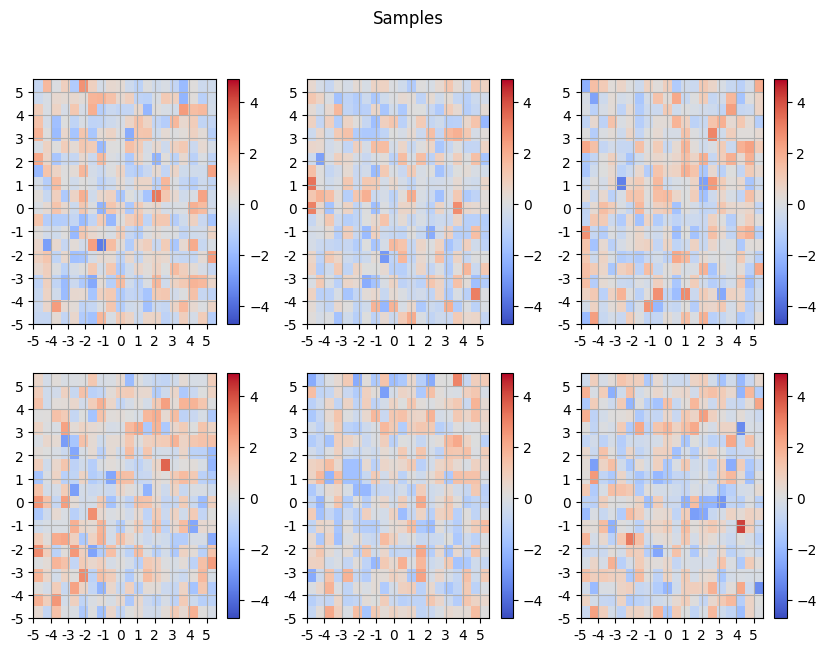

Conv 1, NO reg
Conv 3
Conv 5, NO reg
Conv 7, NO reg


In [ ]:
respcas = []
resspcas = []
rescae1s = []
rescae3s = []
rescae5s = []
rescae7s = []
ressaes = []
fubpcas = []
fubspcas = []
fubcae1s = []
fubcae3s = []
fubcae5s = []
fubcae7s = []
fubsaes = []
pcalambdaindexs = []
spcalambdaindexs = []
slambdaindexs = []
cae1lambdaindexs = []
cae3lambdaindexs = []
cae5lambdaindexs = []
cae7lambdaindexs = []
rescae9s = []

for i in range(40,50):
  Y2, p2, lambda_2 = poissondatagenerator(phit = phit, seeds = i, means = [0,0], covmat = np.diag([9,4]), numsample = 500, dim2 = 2, num_plots=6)
  pcaresindex, cres1index, cres3index, cres5index ,cres7index, pcabestloading, eaephi1, eaephi3, eaephi5,eaephi7 = spatialAE2D(Y = Y2, p = p2,activations = 'relu',  lambda_ = lambda_2, epoches = 500, padding0 = 'same', regg = 0, dense = 0)
  respcas.append(pcaresindex)

  rescae1s.append(cres1index)
  rescae3s.append(cres3index)
  rescae5s.append(cres5index)
  rescae7s.append(cres7index)

  rescae9s.append(np.min([cres1index, cres3index, cres5index, cres7index]))

  pd.DataFrame([respcas,rescae1s,rescae3s,rescae5s,rescae7s,rescae9s]).to_csv('/content/drive/MyDrive/master/20240704/res40to50(nonlinear2D).csv')
  print(i)


In [ ]:
respcas = []
resspcas = []
rescae1s = []
rescae3s = []
rescae5s = []
rescae7s = []
ressaes = []
fubpcas = []
fubspcas = []
fubcae1s = []
fubcae3s = []
fubcae5s = []
fubcae7s = []
fubsaes = []
pcalambdaindexs = []
spcalambdaindexs = []
slambdaindexs = []
cae1lambdaindexs = []
cae3lambdaindexs = []
cae5lambdaindexs = []
cae7lambdaindexs = []
rescae9s = []

for i in range(50,60):
  Y2, p2, lambda_2 = poissondatagenerator(phit = phit, seeds = i, means = [0,0], covmat = np.diag([9,4]), numsample = 500, dim2 = 2, num_plots=6)
  pcaresindex, cres1index, cres3index, cres5index ,cres7index, pcabestloading, eaephi1, eaephi3, eaephi5,eaephi7 = spatialAE2D(Y = Y2, p = p2,activations = 'relu',  lambda_ = lambda_2, epoches = 500, padding0 = 'same', regg = 0, dense = 0)
  respcas.append(pcaresindex)

  rescae1s.append(cres1index)
  rescae3s.append(cres3index)
  rescae5s.append(cres5index)
  rescae7s.append(cres7index)

  rescae9s.append(np.min([cres1index, cres3index, cres5index, cres7index]))

  pd.DataFrame([respcas,rescae1s,rescae3s,rescae5s,rescae7s,rescae9s]).to_csv('/content/drive/MyDrive/master/20240704/res50to60(nonlinear2D).csv')
  print(i)
